# APIM ❤️ OpenAI

## Backend pool Load Balancing lab
![flow](../../images/backend-pool-load-balancing.gif)

Playground to try the built-in load balancing [backend pool functionality of APIM](https://learn.microsoft.com/en-us/azure/api-management/backends?tabs=bicep) to either a list of Azure OpenAI endpoints or mock servers.

Notes:
- The backend pool uses round-robin by default
- But priority and weight based routing are also supported: Adjust the `priority` (the lower the number, the higher the priority) and `weight` parameters in the `openai_resources` variable
- The `retry` API Management policy initiates a retry to an available backend if an HTTP 429 status code is encountered
- Use the mock servers by cleaning the `openai_resources` variable and simulate custom behavior by changing the code in the [app.py](../../tools/mock-server/app.py) file 

### Result
![result](result.png)

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

Repeat the same test using the Python SDK to ensure compatibility.

In [30]:
apim_resource_gateway_url = ! terraform output -raw apim_resource_gateway_url
apim_resource_gateway_url = apim_resource_gateway_url.n
apim_subscription_key = ! terraform output -raw apim_subscription_key
apim_subscription_key = apim_subscription_key.n
openai_api_version = "2024-10-21"
openai_model_name = "gpt-4o"
openai_deployment_name = "gpt-4o"

print("APIM Resource Gateway URL: ", apim_resource_gateway_url)
print("APIM Subscription Key: ", apim_subscription_key)

APIM Resource Gateway URL:  https://apim-external-300prod.azure-api.net
APIM Subscription Key:  da0ffc371d324190b27991f4ac0e17e9


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call
Requests is an elegant and simple HTTP library for Python that will be used here to make raw API requests and inspect the responses. 

You will not see HTTP 429s returned as API Management's `retry` policy will select an available backend. If no backends are viable, an HTTP 503 will be returned.

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior of the backend pool.

In [31]:
import time
import os
import json
import datetime
import requests

runs = 20
sleep_time_ms = 200
url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []

for i in range(runs):
    print("▶️ Run:", i+1, "/", runs)
    

    messages={"messages":[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}

    start_time = time.time()
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    response_time = time.time() - start_time
    
    print(f"⌚ {response_time:.2f} seconds")
    # Check the response status code and apply formatting
    if 200 <= response.status_code < 300:
        status_code_str = '\x1b[1;32m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and green
    elif response.status_code >= 400:
        status_code_str = '\x1b[1;31m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and red
    else:
        status_code_str = str(response.status_code)  # No formatting

    # Print the response status with the appropriate formatting
    print("Response status:", status_code_str)
    
    print("Response headers:", response.headers)
    
    if "x-ms-region" in response.headers:
        print("x-ms-region:", '\x1b[1;31m'+response.headers.get("x-ms-region")+'\x1b[0m') # this header is useful to determine the region of the backend that served the request
        api_runs.append((response_time, response.headers.get("x-ms-region")))
    
    if (response.status_code == 200):
        data = json.loads(response.text)
        print("Token usage:", data.get("usage"), "\n")
        print("💬 ", data.get("choices")[0].get("message").get("content"), "\n")
    else:
        print(response.text)   

    time.sleep(sleep_time_ms/1000)

▶️ Run: 1 / 20
⌚ 1.13 seconds
Response status: 200 - OK
Response headers: {'Content-Type': 'application/json', 'Date': 'Sat, 14 Dec 2024 11:27:29 GMT', 'Cache-Control': 'private', 'Content-Encoding': 'gzip', 'Transfer-Encoding': 'chunked', 'Vary': 'Accept-Encoding', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'apim-request-id': 'f2db6c61-0769-4927-9a46-0ea967ff1a62', 'x-ratelimit-remaining-requests': '199', 'x-accel-buffering': 'no', 'x-ms-rai-invoked': 'true', 'X-Request-ID': '6c9959a1-4dc4-447d-a260-f373c6d6f16b', 'X-Content-Type-Options': 'nosniff', 'azureml-model-session': 'd067-20241120171340', 'x-ms-region': 'France Central', 'x-envoy-upstream-service-time': '691', 'x-ms-client-request-id': 'Not-Set', 'x-ratelimit-remaining-tokens': '19340'}
x-ms-region: France Central
Token usage: {'completion_tokens': 53, 'prompt_tokens': 30, 'total_tokens': 83} 

💬  Sure! But first, let me just reach through your screen, grab your phone, and check the time for 

<a id='plot'></a>
### 🔍 Analyze Load Balancing results

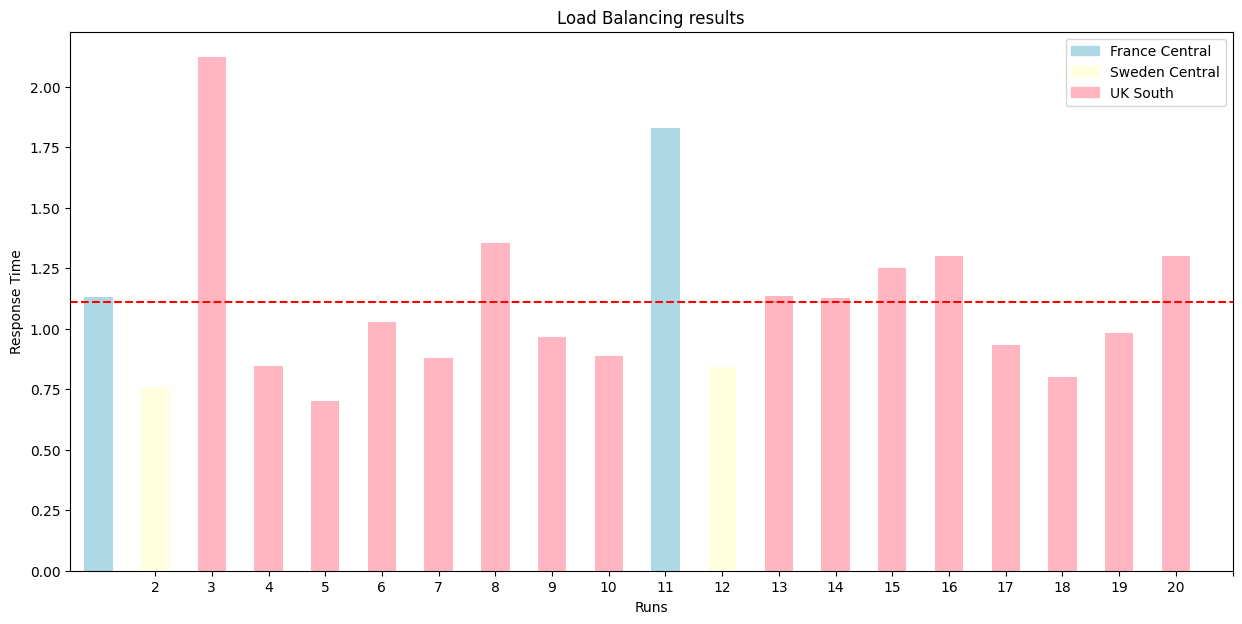

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Response Time', 'Region'])
df['Run'] = range(1, len(df) + 1)

# Define a color map for each region
color_map = {'UK South': 'lightpink', 'France Central': 'lightblue', 'Sweden Central': 'lightyellow', 'Region3': 'red', 'Region4': 'orange'}  # Add more regions and colors as needed

# Plot the dataframe with colored bars
ax = df.plot(kind='bar', x='Run', y='Response Time', color=[color_map.get(region, 'gray') for region in df['Region']], legend=False)

# Add legend
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=color_map.get(region, 'gray')) for region in df['Region'].unique()]
ax.legend(legend_labels, df['Region'].unique())

plt.title('Load Balancing results')
plt.xlabel('Runs')
plt.ylabel('Response Time')
plt.xticks(df['Run'], rotation=0)

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')

plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

Repeat the same test using the Python SDK to ensure compatibility.

In [ ]:
import time
from openai import AzureOpenAI

runs = 9
sleep_time_ms = 0

for i in range(runs):
    print("▶️ Run: ", i+1)

    messages=[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]

    client = AzureOpenAI(
        azure_endpoint=apim_resource_gateway_url,
        api_key=apim_subscription_key,
        api_version=openai_api_version
    )

    start_time = time.time()

    response = client.chat.completions.create(model=openai_model_name, messages=messages)
    
    response_time = time.time() - start_time
    print(f"⌚ {response_time:.2f} seconds")
    print("💬 ", response.choices[0].message.content)
    time.sleep(sleep_time_ms/1000)


▶️ Run:  1
⌚ 0.81 seconds
💬  Oh sure, let me just get my sundial out. Oh wait, I forgot, I can't actually see the sun or a clock. How about you just check your own device, hmm?
▶️ Run:  2
⌚ 0.85 seconds
💬  Sure! Just let me grab my time-traveling device and… Oh wait, sorry, I forgot, I'm stuck inside this computer with no concept of real time. Maybe checking a clock might be a bit more reliable?
▶️ Run:  3
⌚ 0.95 seconds
💬  Oh sure, let me just check my sundial real quick! But seriously, you might want to check a clock or your phone because I can't actually tell you the current time.
▶️ Run:  4
⌚ 0.92 seconds
💬  Oh, absolutely! Let me just check my imaginary watch that runs on sarcasm. It's precisely "who-knows-o'clock." I suggest you check a clock or a phone for a more precise answer!
▶️ Run:  5
⌚ 0.77 seconds
💬  Oh, of course! Let me just reach into the digital void and check my non-existent clock for you. It's definitely some time between yesterday and tomorrow. Hope that helps!
▶️ 